In [1]:
from pathlib import Path
from collections import Counter
import joblib
import pprint

import cv2
import numpy as np
from torch.utils.data import ConcatDataset, DataLoader
import matplotlib.pyplot as plt

from dataloader import CarlaDataset, load_all_datasets_in_folder
from dataloader import Instance # type: ignore


# reload local imports
%load_ext autoreload
%autoreload 2

In [106]:
train_sets = ["camera1", "camera2", "camera3", "camera4"]
all_datasets = load_all_datasets_in_folder(Path("../datasets"))
train_sets = [dataset for dataset in all_datasets if dataset.name != "carla_dataset"]
test_sets = [dataset for dataset in all_datasets if dataset.name == "carla_dataset"]

In [98]:
pp=pprint.PrettyPrinter(indent=4) 

In [99]:
all_datasets[0].homography

array([[-6.41764528e-02, -1.76124303e+00,  5.50658177e+02],
       [-2.06703165e-01, -1.29184413e+00,  7.63549160e+02],
       [-1.88418031e-06, -2.55334662e-03,  1.00000000e+00]])

In [63]:
train_set: ConcatDataset[CarlaDataset] = ConcatDataset(train_sets)
test_set: ConcatDataset[CarlaDataset] = ConcatDataset(test_sets)

In [48]:
hulls = [instance[0] for instance in iter(train_set)]
gcps = np.array([instance[1] for instance in iter(train_set)])
assert len(hulls) == len(gcps)
print(len(hulls))

9538


In [27]:
hulls = [instance[0] for instance in iter(all_datasets[1])]
gcps = np.array([instance[1] for instance in iter(all_datasets[1])])
assert len(hulls) == len(gcps)
print(len(hulls))

615


In [17]:
hulls = [instance[0] for instance in iter(test_set)]
gcps = np.array([instance[1] for instance in iter(test_set)])
assert len(hulls) == len(gcps)
print(len(hulls))

265


76


<BarContainer object of 66 artists>

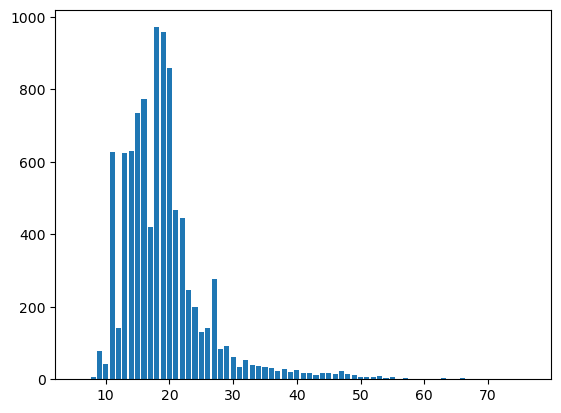

In [49]:
number_of_hulls = list(map(lambda x: len(x), hulls))
length_counter = Counter(number_of_hulls)
print(max(length_counter))
plt.bar(length_counter.keys(), length_counter.values()) # type: ignore

In [108]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, LinearSVR
from sklearn.pipeline import make_pipeline  
from utils import fit_and_score, HardCodedEstimator, PadHull, ScaleToImage, FlattenCoordinates

n_points_per_hull = 100
image_width = 1920
image_height = 1080
random_state = 42

scaled_pipeline = make_pipeline(PadHull(False, n_points_per_hull),
                               ScaleToImage(image_width, image_height),
                               FlattenCoordinates(n_points_per_hull),
                               StandardScaler()) # ridge needs standard scaler

non_scaled_pipeline = make_pipeline(PadHull(False, n_points_per_hull),
                            ScaleToImage(image_width, image_height),
                            FlattenCoordinates(n_points_per_hull),
                            )


# commented out models don't work
regressors = [
    (Ridge(random_state=random_state), scaled_pipeline),
    #(RegressorChain(SVR()), scaled_pipeline),
    #(MultiOutputRegressor(SVR()), scaled_pipeline),
    (RegressorChain(GradientBoostingRegressor(n_estimators=60, random_state=random_state)), non_scaled_pipeline),
    (MultiOutputRegressor(GradientBoostingRegressor(n_estimators=60, random_state=random_state)), non_scaled_pipeline),
    #(RegressorChain(LinearSVR()), scaled_pipeline),
    # MultiOutputRegressor(LinearSVR()),0
    #(DecisionTreeRegressor(max_depth=18, random_state=random_state), non_scaled_pipeline),
    (HardCodedEstimator("homography_matrix.json", 4), None),
]
evaluation = fit_and_score(regressors, hulls, gcps, random_state=random_state)
pp.pprint(evaluation)
_=joblib.dump(evaluation, "regressors.joblib")

100%|██████████| 4/4 [00:53<00:00, 13.27s/it]

[   {   'classifier': MultiOutputRegressor(estimator=GradientBoostingRegressor(n_estimators=60,
                                                         random_state=42)),
        'pipeline': Pipeline(steps=[('padhull', PadHull(n_points=100, shuffle=False)),
                ('scaletoimage', ScaleToImage(height=1080, width=1920)),
                ('flattencoordinates', FlattenCoordinates(n_coordinates=100))]),
        'test_mse': 925.5668914022767,
        'train_mse': 517.3592919945679},
    {   'classifier': RegressorChain(base_estimator=GradientBoostingRegressor(n_estimators=60,
                                                        random_state=42)),
        'pipeline': Pipeline(steps=[('padhull', PadHull(n_points=100, shuffle=False)),
                ('scaletoimage', ScaleToImage(height=1080, width=1920)),
                ('flattencoordinates', FlattenCoordinates(n_coordinates=100))]),
        'test_mse': 945.4720902952765,
        'train_mse': 527.3488476987254},
    {   'classif

In [8]:
_=joblib.dump(evaluation, "classifiers.joblib")

/tmp/ipykernel_34751/4162055314.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  _=fig.show()


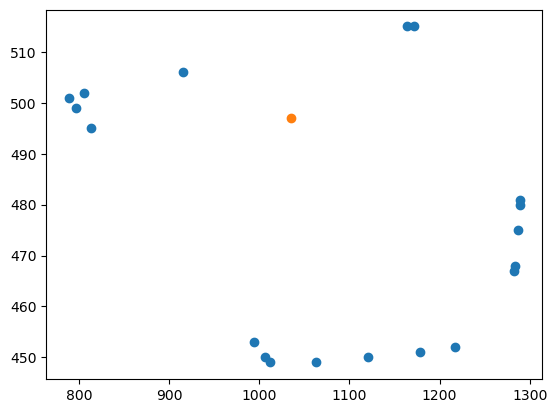

In [33]:
instance = all_datasets[25]
fig, axis = plt.subplots()
axis.scatter(instance[0][:, 1], instance[0][:, 0])
axis.scatter(instance[1][0], instance[1][1])
_=fig.show()

In [10]:
#fig, axis = plt.subplots()
instance = non_scaled_pipeline.transform([instance])
instance

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

camera3
camera1
more_angles
camera2
camera4
carla_dataset


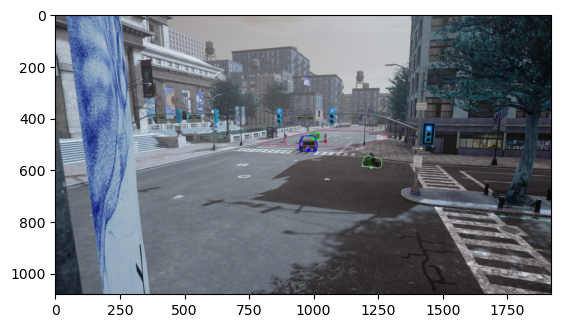

In [94]:
for dataset in all_datasets:
    print(dataset.name)

instance = all_datasets[0].get_frame(10)
fig, axis = plt.subplots()
pv, tv = instance.annotate_images()
axis.imshow(pv)

carla_dataset
array([[-4.07449326e-01, -8.12937538e+00,  8.25162057e+02],
       [ 6.81756015e-01, -6.06104450e+00,  2.59755303e+02],
       [-2.47799764e-05, -1.82750641e-02,  1.00000000e+00]])
array([[-4.07449326e-01, -8.12937538e+00,  8.25162057e+02],
       [ 6.81756015e-01, -6.06104450e+00,  2.59755303e+02],
       [-2.47799764e-05, -1.82750641e-02,  1.00000000e+00]])


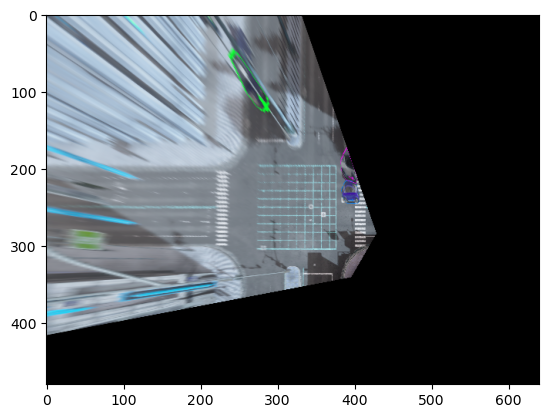

In [107]:
dataset = all_datasets[-1]
print(dataset.name)
pp.pprint(dataset.homography)
gcps_pv = [dataset.get_instance(i).gcp_pv for i in range(len(dataset))]
gcps_tv = [dataset.get_instance(i).gcp_tv for i in range(len(dataset))]
gcps_pv = np.array(gcps_pv).astype(np.float32)
gcps_tv = np.array(gcps_tv).astype(np.float32)
instance = dataset.get_frame(10)
fig, axis = plt.subplots()
pv, tv = instance.annotate_images()
pp.pprint(homography)
output = cv2.warpPerspective(np.asarray(pv), dataset.homography, (640, 480))
plt.imshow(output)

In [86]:
gcps_tv.shape

(265, 2)